In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
def sim_future(x0, sigma,   horizon, func="gauss"): 
    if func == "gauss":
        pred = np.array([x0])
        for i in range(horizon):
            pred = np.concatenate([pred,  np.array([np.random.normal(loc=pred[i], scale=sigma)])])
    return pred

def percentile_range(data, lower=2.5, upper=97.5, axis=1):
    lower_bounds = np.percentile(data, lower, axis=axis)
    upper_bounds = np.percentile(data, upper, axis=axis)
    return lower_bounds, upper_bounds



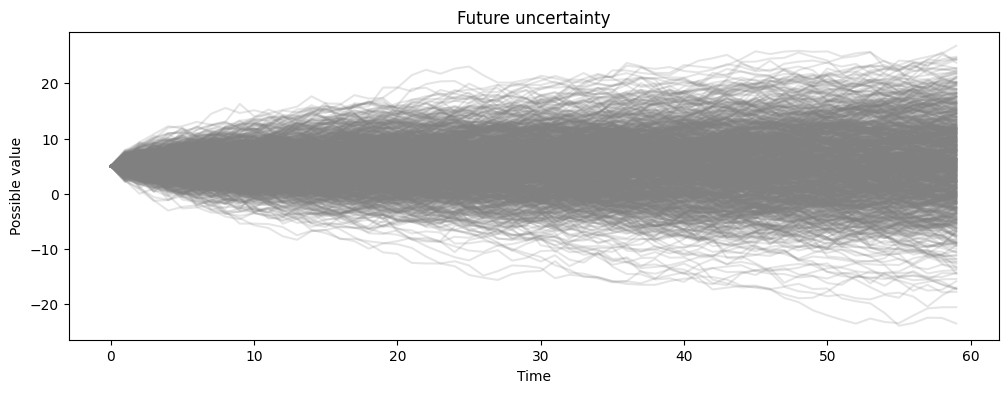

(-40.0, 40.0)

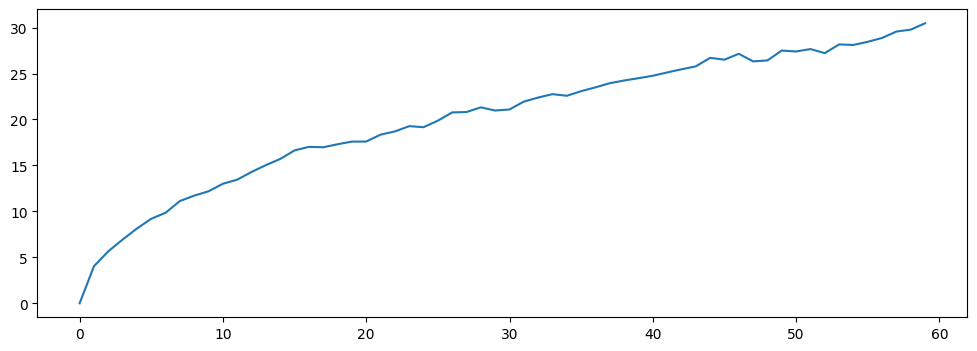

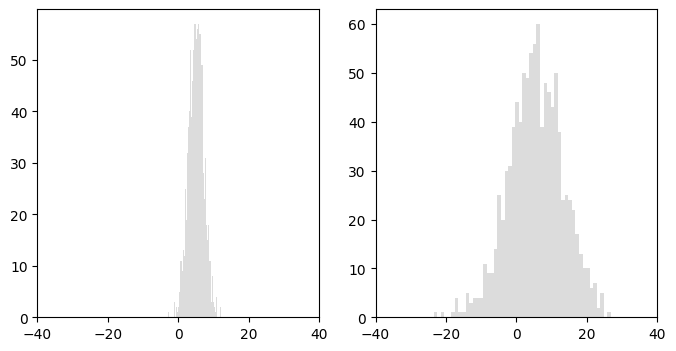

In [ ]:
horizon = 60

f, ax = plt.subplots(1,1,figsize=(12,4))
niter = 1000
walks =  np.zeros((niter, horizon))
for iter in range(niter): 
    walks[iter,:] = sim_future(5, 1,   horizon-1, func="gauss")
    ax.plot(walks[iter,:], color="gray", alpha=0.2)
plt.title("Future uncertainty")
plt.xlabel("Time")

f, ax = plt.subplots(1,1,figsize=(12,4))
low_ci, high_ci = percentile_range(walks, axis=0)
ax.plot(np.arange(0,horizon), high_ci-low_ci) 


f, ax2 = plt.subplots(1,2, figsize=(8,4))
ax2[0].hist(walks[:,4], color="darkgray", alpha=0.4, bins=50)
ax2[0].set_xlim([-40, 40])
ax2[1].hist(walks[:,59], color="darkgray", alpha=0.4, bins=50)
ax2[1].set_xlim([-40, 40])

In [40]:
high_ci-low_ci

array([ 0.        ,  3.91814142,  5.54052487,  6.92730598,  7.79791826,
        8.72138963,  9.68716004, 10.44337435, 10.74253027, 11.73403434,
       11.9284795 , 12.96229451, 13.82962624, 14.42347915, 14.58550101,
       14.73717936, 15.43511779, 16.34338572, 17.22785315, 17.07576861,
       17.60165534, 18.05824148, 18.76941467, 19.28751174, 19.22423717,
       20.5920776 , 20.66942669, 21.09268052, 21.52445454, 22.344615  ,
       22.75981116, 23.38880247, 23.71756172, 23.43187005, 23.78163116,
       23.83652819, 24.40507013, 24.35749309, 25.43520911, 26.45242529,
       26.48692988, 26.57573177, 27.27090388, 27.17884409, 27.45199684,
       27.85018655, 28.32248562, 28.21793245, 27.7810285 , 28.34334194,
       28.6122007 , 27.8711344 , 28.61119928, 28.79923025, 29.6044683 ,
       29.38149949, 29.1261352 , 30.55086902, 30.08721457, 30.18011437])

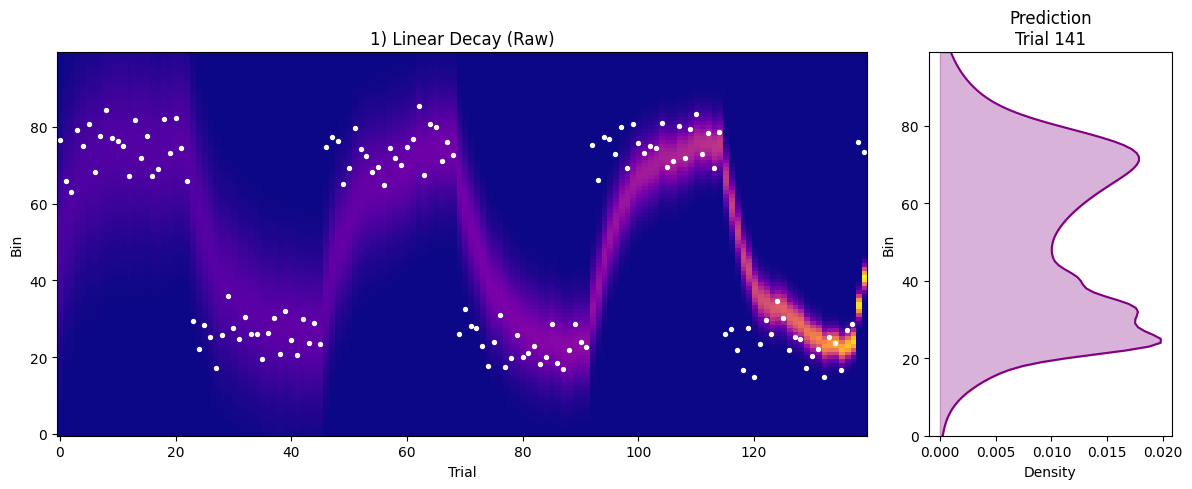

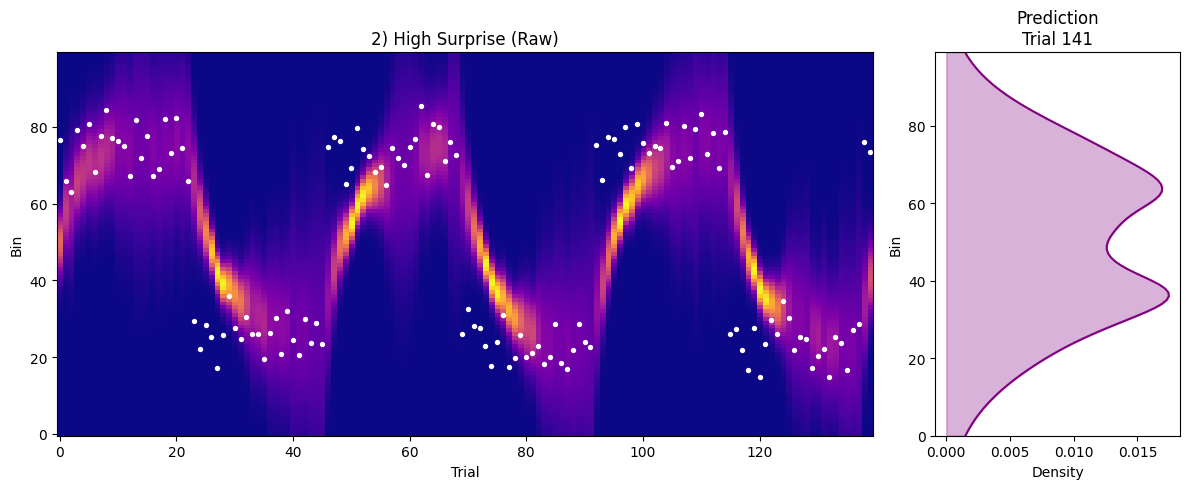

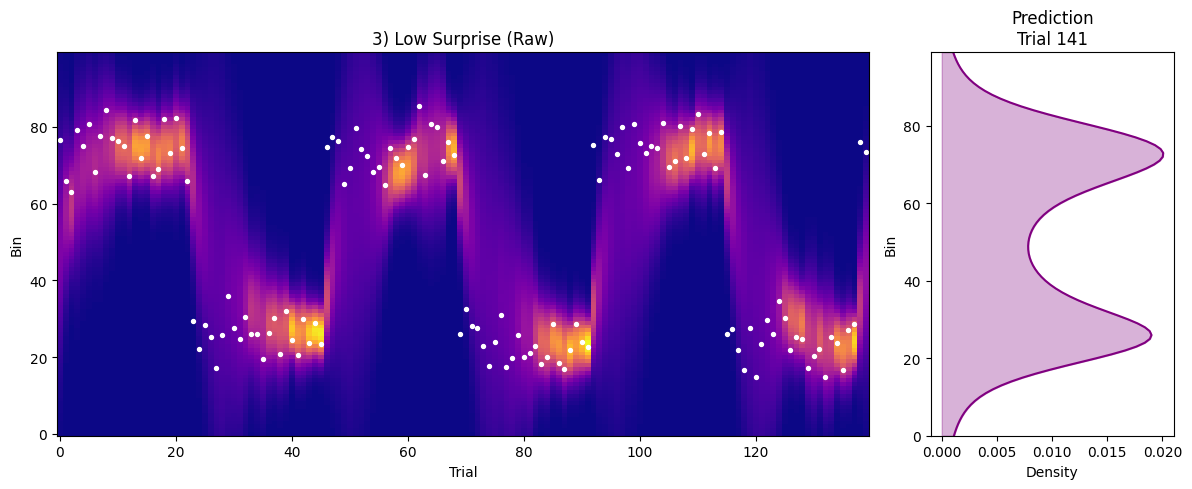

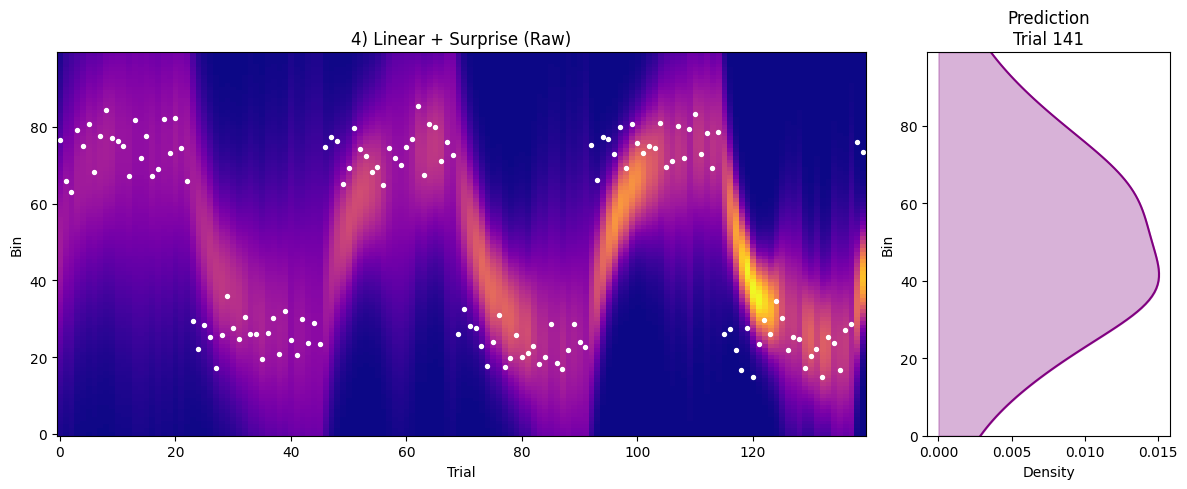

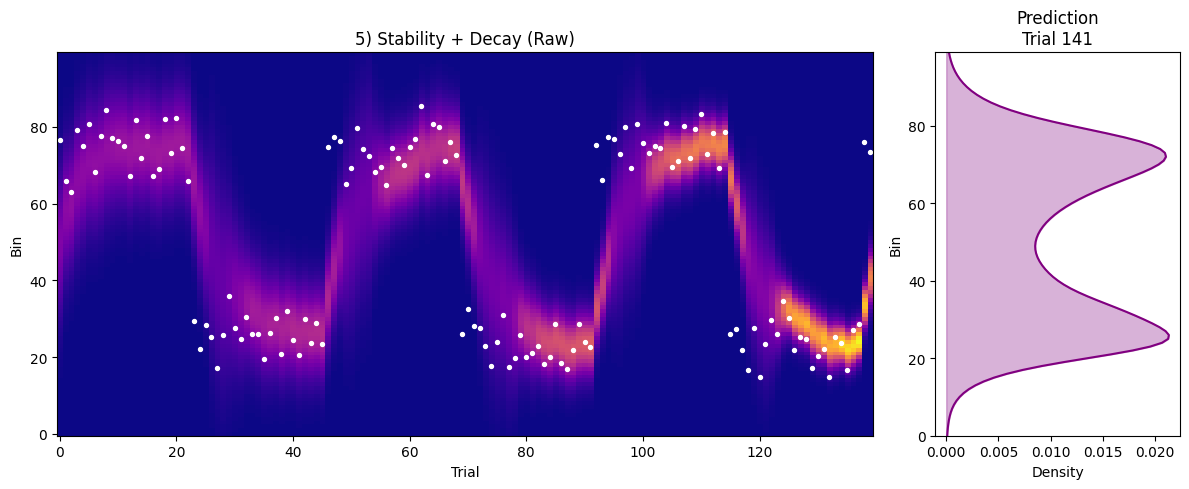

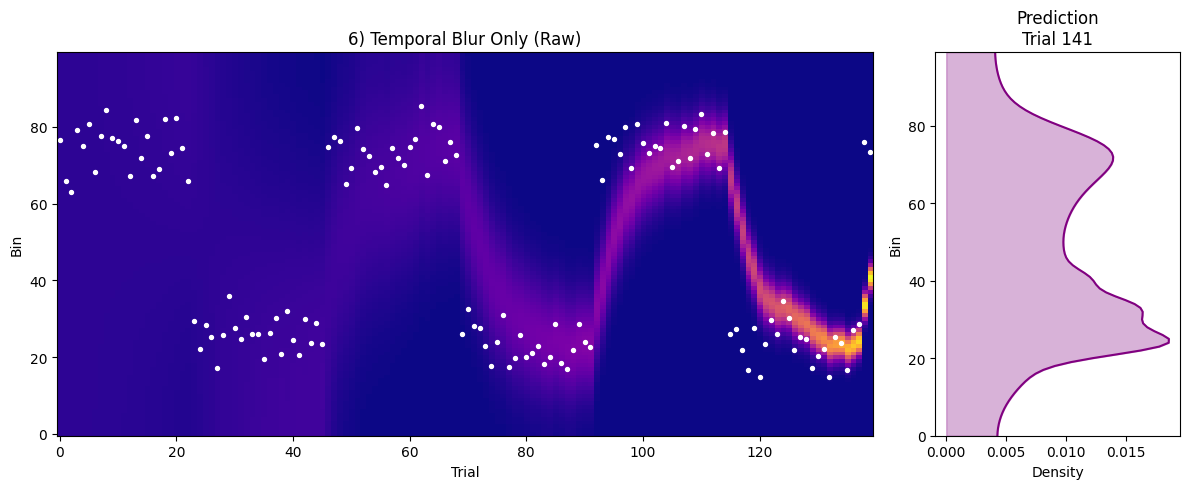

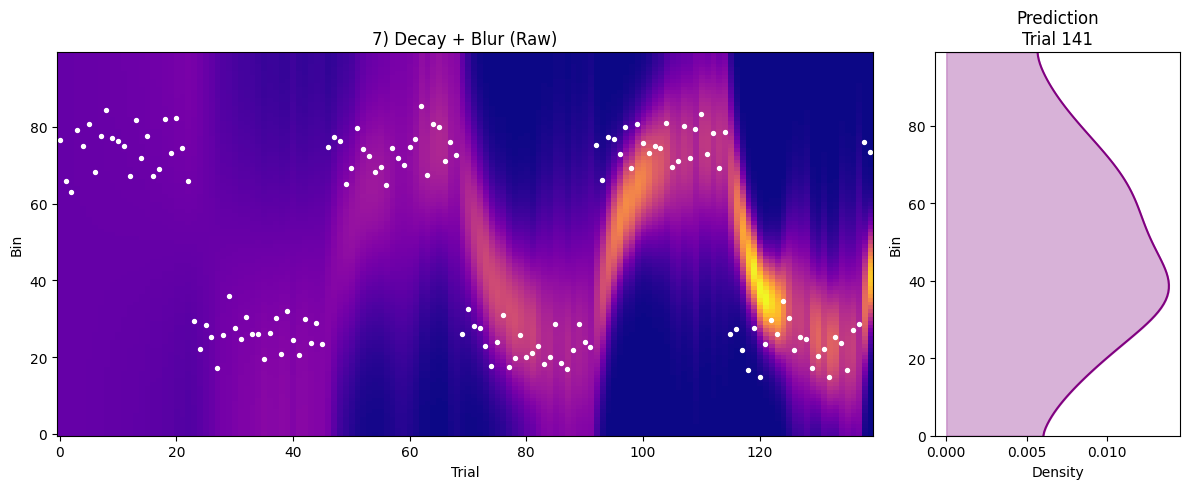

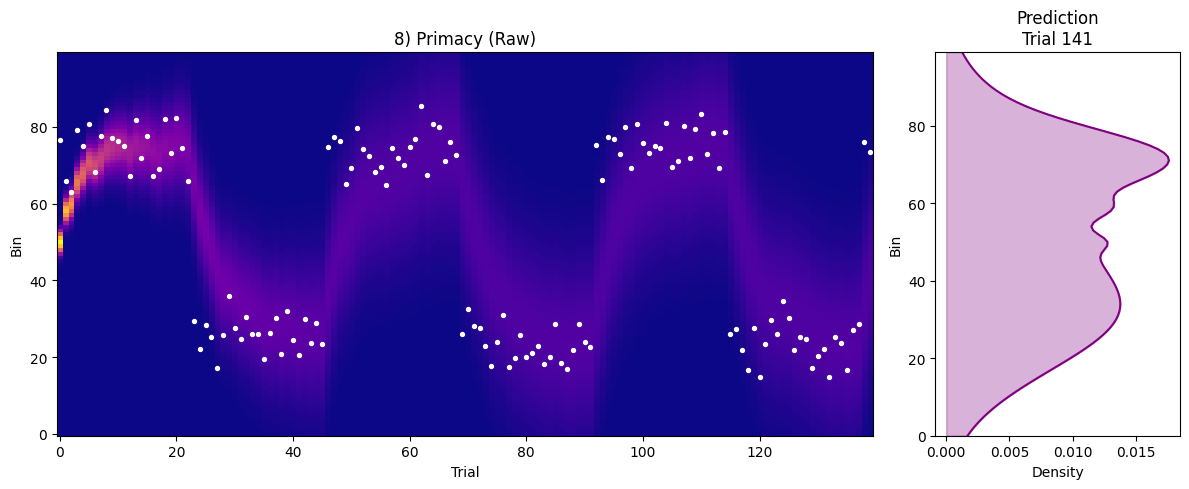

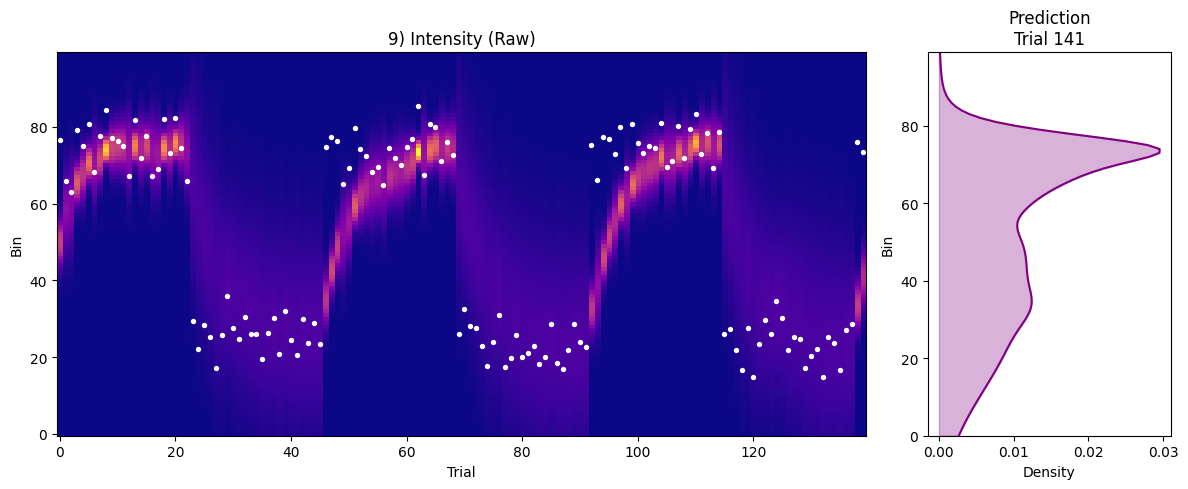

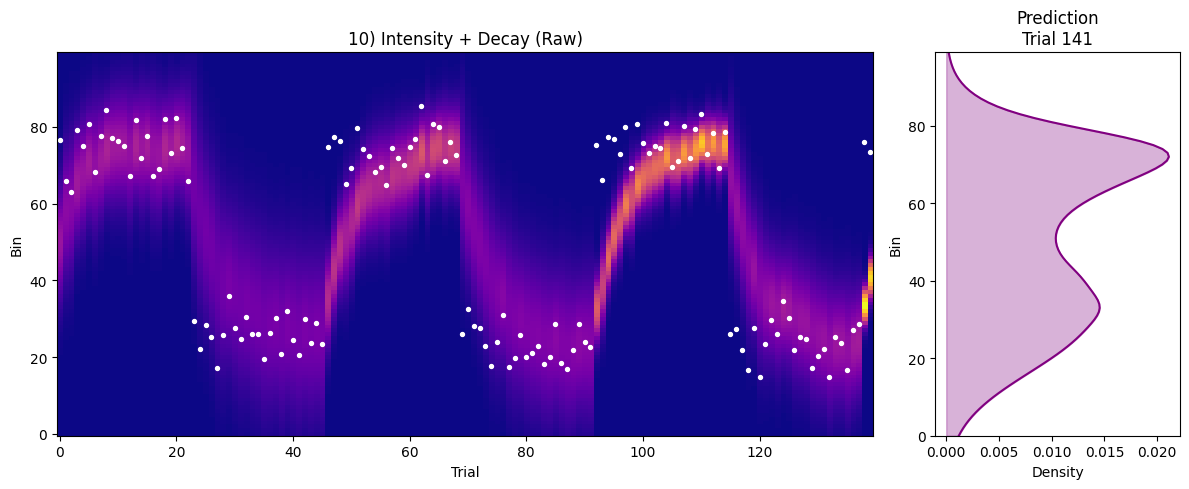

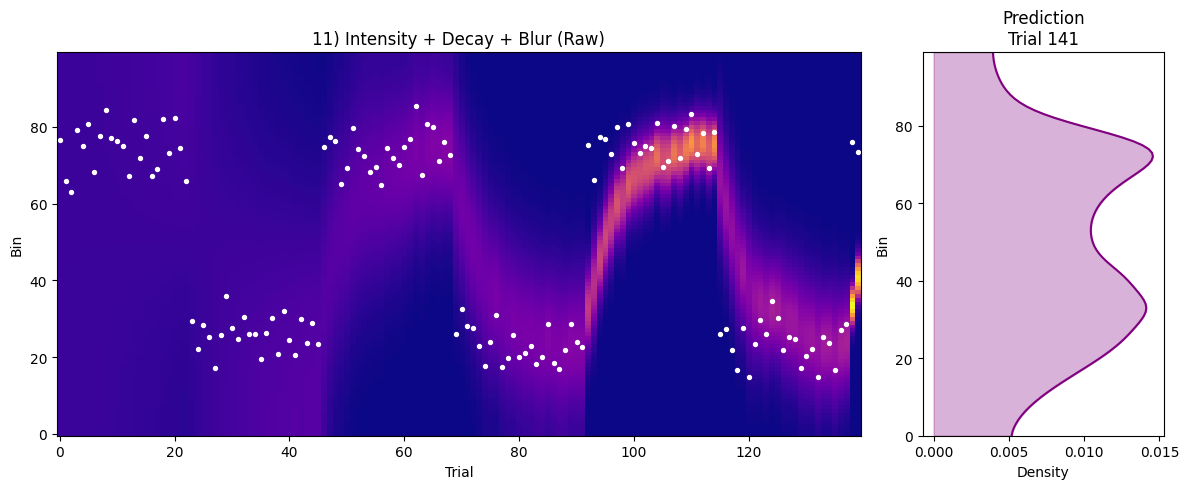

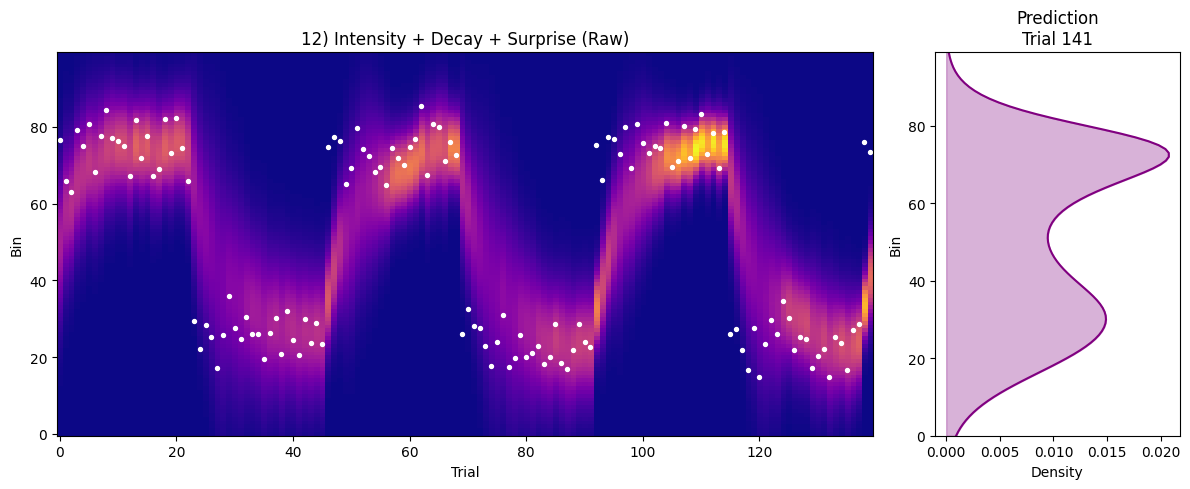

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d

# ----- CONFIGURATION -----
n_trials = 140
bins = np.arange(100)
final_trial = n_trials - 1
true_sd = 5.0
process_var = 1.0
measurement_var = 25.0
window_size = 5

# ----- 1. DATA GENERATION: 6 phases (3 high, 3 low) -----
n_phases = 6
block_size = n_trials // n_phases
true_means = np.array([75 if (t // block_size) % 2 == 0 else 25 for t in range(n_trials)])
observations = np.random.normal(loc=true_means, scale=true_sd)

# ----- 2. KALMAN FILTER -----
mu_est = np.zeros(n_trials)
var_est = np.zeros(n_trials)
mu_est[0] = 50.0
var_est[0] = 25.0

for t in range(1, n_trials):
    mu_pred = mu_est[t - 1]
    var_pred = var_est[t - 1] + process_var
    K = var_pred / (var_pred + measurement_var)
    mu_est[t] = mu_pred + K * (observations[t] - mu_pred)
    var_est[t] = (1 - K) * var_pred

# ----- 3. SURPRISE METRICS -----
shannon_surprise = np.zeros(n_trials)
for t in range(n_trials):
    mu_prior = mu_est[t - 1] if t > 0 else mu_est[0]
    sd_prior = np.sqrt(var_est[t - 1]) if t > 0 else np.sqrt(var_est[0])
    likelihood = norm.pdf(observations[t], loc=mu_prior, scale=sd_prior)
    shannon_surprise[t] = -np.log(likelihood + 1e-12)

trailing_surprise = np.zeros(n_trials)
for t in range(n_trials):
    start = max(0, t - window_size + 1)
    trailing_surprise[t] = np.mean(shannon_surprise[start:t+1])

# ----- 4. MEMORY MODELS -----
def generate_raw_memory_matrix(sd_list):
    memory = np.zeros((100, n_trials))
    for t in range(n_trials):
        memory[:, t] = norm.pdf(bins, loc=mu_est[t], scale=sd_list[t])
        memory[:, t] /= memory[:, t].sum()
    return memory

def apply_temporal_blur_exponential(memory_matrix, base_sigma=1.0, tau=30.0):
    blurred_matrix = np.zeros_like(memory_matrix)
    for t in range(n_trials):
        distance = final_trial - t
        sigma = base_sigma * np.exp(distance / tau)
        blurred_matrix[:, t] = gaussian_filter1d(memory_matrix[:, t], sigma=sigma)
        blurred_matrix[:, t] /= blurred_matrix[:, t].sum()
    return blurred_matrix

def generate_primacy_sd_plateau(base_sd=2.0, scale=20.0, tau=60.0, plateau=15.0):
    sd = np.array([base_sd + scale * (1 - np.exp(-t / tau)) for t in range(n_trials)])
    return np.clip(sd, a_min=None, a_max=plateau)

def intensity_to_sd(intensity, min_sd=2.0, max_sd=20.0):
    return max_sd - intensity * (max_sd - min_sd)

def compute_prediction_distribution_simple(memory_matrix):
    posterior = memory_matrix.sum(axis=1)
    posterior /= posterior.sum()
    return posterior

def plot_memory_prediction_vertical_simple(memory_matrix, title):
    pred_dist = compute_prediction_distribution_simple(memory_matrix)
    x = np.arange(100)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 0.3]})

    axs[0].imshow(memory_matrix, aspect='auto', origin='lower', cmap='plasma')
    axs[0].scatter(np.arange(n_trials), np.clip(observations, 0, 99), color='white', s=8)
    axs[0].set_title(f"{title} (Raw)")
    axs[0].set_xlabel("Trial")
    axs[0].set_ylabel("Bin")

    #normalized = memory_matrix / memory_matrix.max(axis=0, keepdims=True)
    #axs[1].imshow(normalized, aspect='auto', origin='lower', cmap='plasma')
    #axs[1].scatter(np.arange(n_trials), np.clip(observations, 0, 99), color='white', s=8)
    #axs[1].set_title(f"{title} (Normalized)")
    #axs[1].set_xlabel("Trial")

    axs[1].plot(pred_dist, x, color='purple')
    axs[1].fill_betweenx(x, 0, pred_dist, color='purple', alpha=0.3)
    axs[1].set_ylim(0, 99)
    axs[1].set_title("Prediction\nTrial 141")
    axs[1].set_ylabel("Bin")
    axs[1].set_xlabel("Density")

    plt.tight_layout()
    plt.show()

# ----- 5. MEMORY MATRICES -----
sd_linear = np.array([2 + 0.1 * (final_trial - t) for t in range(n_trials)])
precision_surprise = 1 + 1.0 * trailing_surprise
sd_surprise = np.maximum(2.0, 100 / precision_surprise)
sd_surprise_low = np.maximum(2.0, precision_surprise)
sd_combined = sd_linear + sd_surprise

sd_stability = np.clip(100 / (1 + (np.max(trailing_surprise) - trailing_surprise)), 2.0, 20.0)
sd_stability_linear = 0.5*(sd_linear + sd_stability)

sd_primacy_plateau = generate_primacy_sd_plateau()

intensity_scaled = (observations - np.min(observations)) / (np.max(observations) - np.min(observations))
sd_intensity = np.array([intensity_to_sd(i) for i in intensity_scaled])
sd_intensity_linear = 0.5*(sd_intensity + sd_linear)
sd_intensity_linear_surprise = 0.33*(sd_intensity + sd_linear + sd_surprise_low)

memory_linear_raw = generate_raw_memory_matrix(sd_linear)
memory_high_surprise_raw = generate_raw_memory_matrix(sd_surprise)
memory_low_surprise_raw = generate_raw_memory_matrix(sd_surprise_low)
memory_combined_raw = generate_raw_memory_matrix(sd_combined)
memory_stability_decay_raw = generate_raw_memory_matrix(sd_stability_linear)
memory_primacy_plateau_raw = generate_raw_memory_matrix(sd_primacy_plateau)
memory_intensity_raw = generate_raw_memory_matrix(sd_intensity)
memory_intensity_linear_raw = generate_raw_memory_matrix(sd_intensity_linear)
memory_intensity_linear_surprise_raw = generate_raw_memory_matrix(sd_intensity_linear_surprise)

memory_blurred_exp_raw = apply_temporal_blur_exponential(memory_linear_raw)
memory_combined_blurred_exp_raw = apply_temporal_blur_exponential(memory_combined_raw)
memory_intensity_linear_blurred_raw = apply_temporal_blur_exponential(memory_intensity_linear_raw)

# ----- 6. PLOT ALL -----
plot_memory_prediction_vertical_simple(memory_linear_raw, "1) Linear Decay")
plot_memory_prediction_vertical_simple(memory_high_surprise_raw, "2) High Surprise")
plot_memory_prediction_vertical_simple(memory_low_surprise_raw, "3) Low Surprise")
plot_memory_prediction_vertical_simple(memory_combined_raw, "4) Linear + Surprise")
plot_memory_prediction_vertical_simple(memory_stability_decay_raw, "5) Stability + Decay")
plot_memory_prediction_vertical_simple(memory_blurred_exp_raw, "6) Temporal Blur Only")
plot_memory_prediction_vertical_simple(memory_combined_blurred_exp_raw, "7) Decay + Blur")
plot_memory_prediction_vertical_simple(memory_primacy_plateau_raw, "8) Primacy")
plot_memory_prediction_vertical_simple(memory_intensity_raw, "9) Intensity")
plot_memory_prediction_vertical_simple(memory_intensity_linear_raw, "10) Intensity + Decay")
plot_memory_prediction_vertical_simple(memory_intensity_linear_blurred_raw, "11) Intensity + Decay + Blur")
plot_memory_prediction_vertical_simple(memory_intensity_linear_surprise_raw, "12) Intensity + Decay + Surprise")





### Infering latent states from posterior distribution

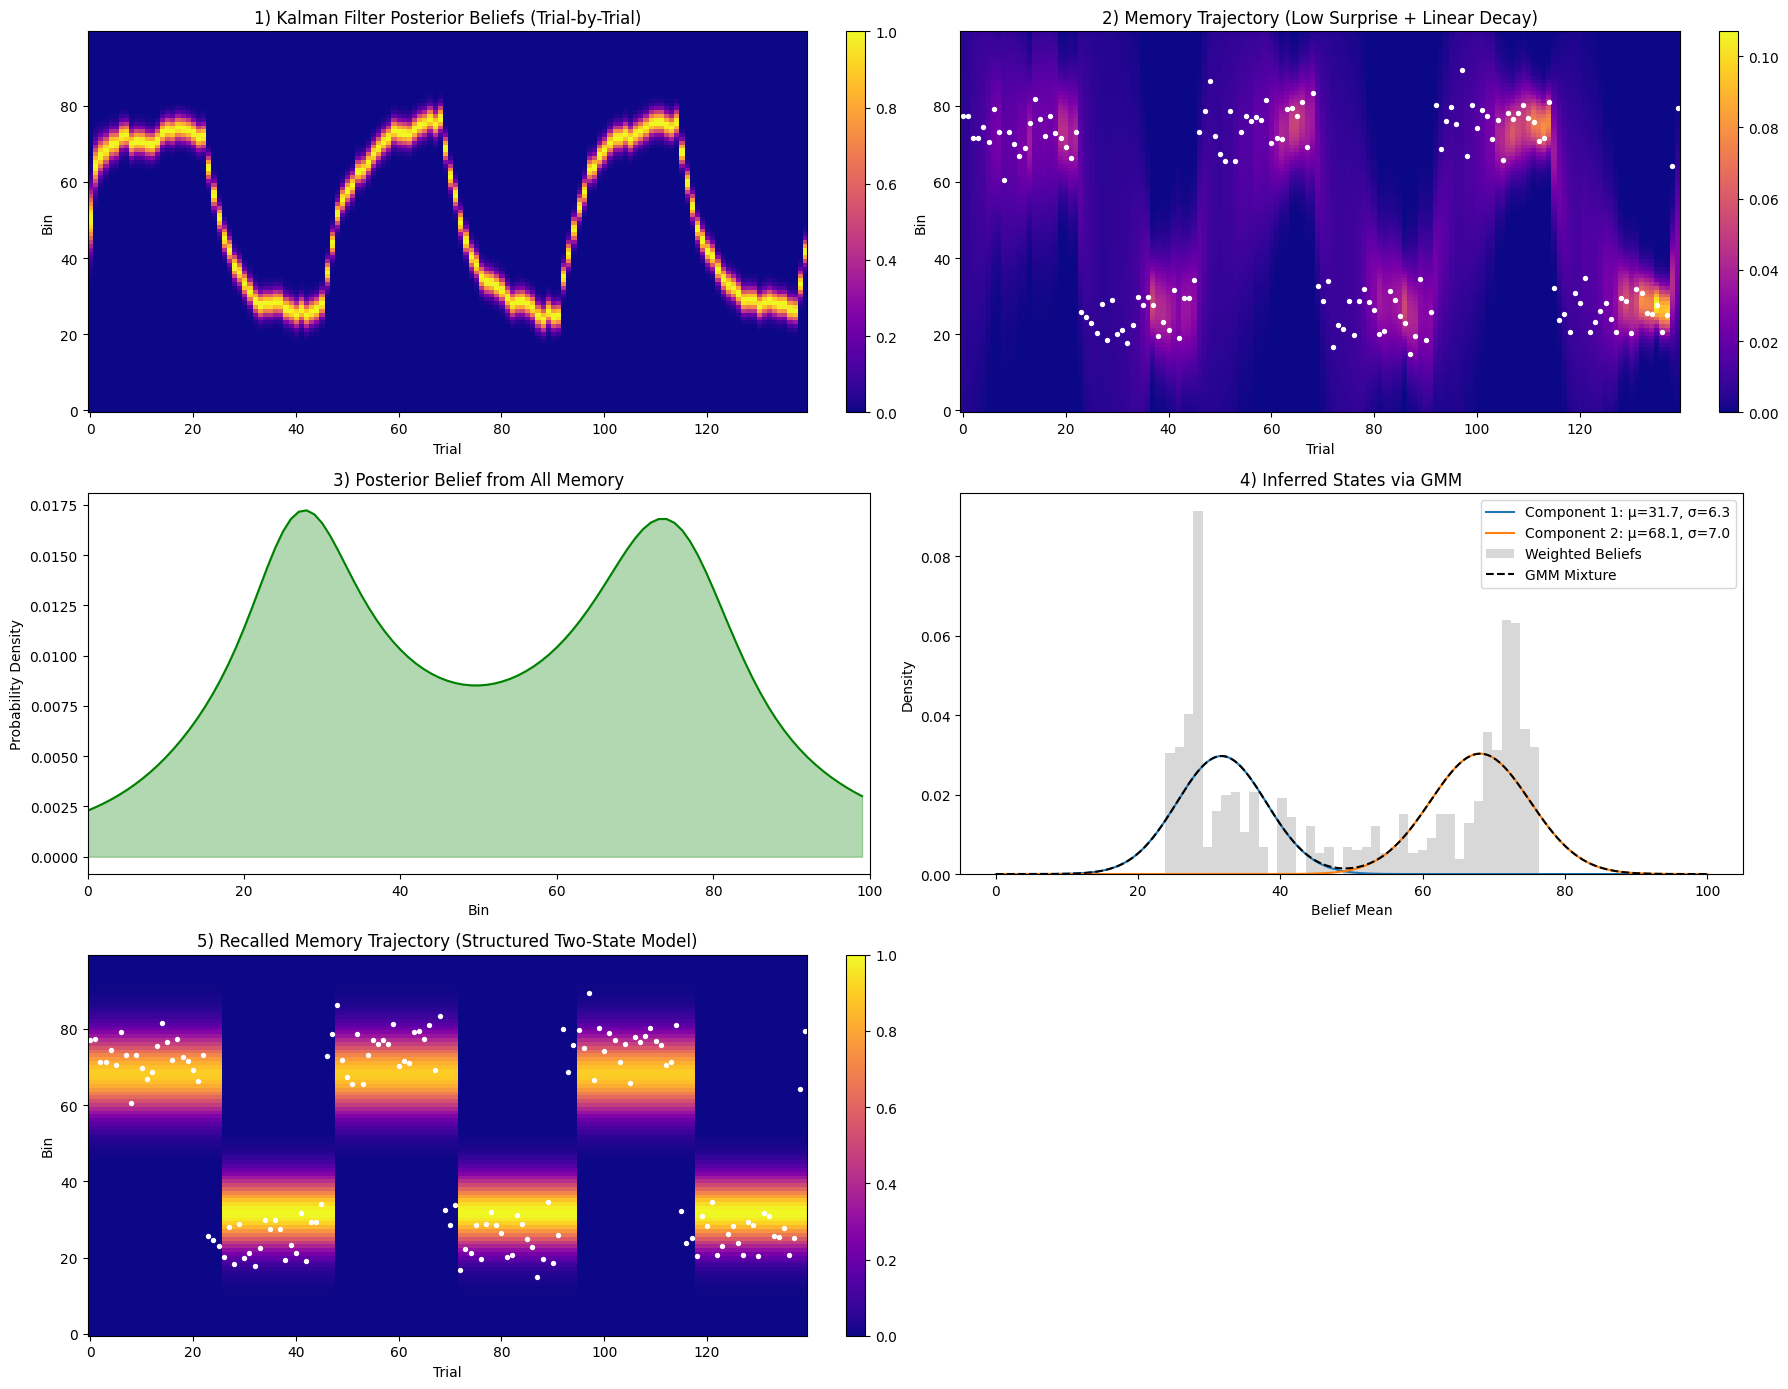

In [45]:

# Much better: assign phases of memory based on Kalman beliefs and smooth state transitions!

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# ----- CONFIGURATION -----
n_trials = 140
bins = np.arange(100)
final_trial = n_trials - 1
true_sd = 5.0
process_var = 1.0
measurement_var = 25.0
window_size = 5
decay_rate = 0.005

# ----- 1. DATA GENERATION -----
n_phases = 6
block_size = n_trials // n_phases
true_means = np.array([75 if (t // block_size) % 2 == 0 else 25 for t in range(n_trials)])
observations = np.random.normal(loc=true_means, scale=true_sd)

# ----- 2. KALMAN FILTER -----
mu_est = np.zeros(n_trials)
var_est = np.zeros(n_trials)
mu_est[0] = 50.0
var_est[0] = 25.0

for t in range(1, n_trials):
    mu_pred = mu_est[t-1]
    var_pred = var_est[t-1] + process_var
    K = var_pred / (var_pred + measurement_var)
    mu_est[t] = mu_pred + K * (observations[t] - mu_pred)
    var_est[t] = (1 - K) * var_pred

# ----- 3. SURPRISE -----
shannon_surprise = np.zeros(n_trials)
for t in range(n_trials):
    mu_prior = mu_est[t-1] if t > 0 else mu_est[0]
    sd_prior = np.sqrt(var_est[t-1]) if t > 0 else np.sqrt(var_est[0])
    likelihood = norm.pdf(observations[t], loc=mu_prior, scale=sd_prior)
    shannon_surprise[t] = -np.log(likelihood + 1e-12)

trailing_surprise = np.zeros(n_trials)
for t in range(n_trials):
    start = max(0, t - window_size + 1)
    trailing_surprise[t] = np.mean(shannon_surprise[start:t+1])

# ----- 4. MEMORY MATRIX (Low Surprise + Decay) -----
precision_surprise = 1 + 1.0 * trailing_surprise
sd_surprise_low = np.maximum(2.0, precision_surprise)

memory_matrix = np.zeros((len(bins), n_trials))
for t in range(n_trials):
    decay_factor = 1.0 - decay_rate * (final_trial - t)
    decay_factor = np.clip(decay_factor, 0.1, 1.0)
    adjusted_sd = sd_surprise_low[t] / decay_factor
    memory_matrix[:, t] = norm.pdf(bins, loc=mu_est[t], scale=adjusted_sd)

# ----- 5. FULL POSTERIOR -----
posterior = memory_matrix.sum(axis=1)
posterior /= posterior.sum()

# ----- 6. GMM FIT -----
posterior_weights = memory_matrix.sum(axis=0)
posterior_weights /= posterior_weights.sum()
sample_indices = np.random.choice(np.arange(n_trials), size=1000, p=posterior_weights)
belief_samples = mu_est[sample_indices].reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=0).fit(belief_samples)
means = gmm.means_.flatten()
covars = np.sqrt(gmm.covariances_.flatten())
weights = gmm.weights_

# ----- 7. STATE ASSIGNMENT BASED ON NEAREST GMM COMPONENT -----
# For each trial, assign to nearest GMM mean
assigned_states = np.argmin(np.abs(mu_est[:, np.newaxis] - means[np.newaxis, :]), axis=1)

# ----- 8. STABILIZE PHASES -----
# Smooth the assignment: only allow a switch if the new state is maintained for 5 consecutive trials
stable_states = assigned_states.copy()
for t in range(5, n_trials):
    # If last 5 trials favor a different state, switch
    if np.all(assigned_states[t-5:t] == assigned_states[t]):
        stable_states[t-5:t] = assigned_states[t]

# ----- 9. SIMULATE TWO-STATE MEMORY -----
memory_two_state = np.zeros((len(bins), n_trials))
for t in range(n_trials):
    state = stable_states[t]
    memory_two_state[:, t] = norm.pdf(bins, loc=means[state], scale=covars[state])

memory_two_state /= memory_two_state.max()

# ----- 10. PLOTTING -----
fig, axs = plt.subplots(3, 2, figsize=(18, 14))

# 1. Kalman Filter Posterior Beliefs
belief_grid = np.zeros((len(bins), n_trials))
for t in range(n_trials):
    belief = norm.pdf(bins, loc=mu_est[t], scale=np.sqrt(var_est[t]))
    belief /= belief.max()
    belief_grid[:, t] = belief

im0 = axs[0, 0].imshow(belief_grid, aspect='auto', origin='lower', cmap='plasma')
axs[0, 0].set_title("1) Kalman Filter Posterior Beliefs (Trial-by-Trial)")
axs[0, 0].set_xlabel("Trial")
axs[0, 0].set_ylabel("Bin")
plt.colorbar(im0, ax=axs[0, 0], fraction=0.03)

# 2. Memory Trajectory (Low Surprise + Linear Decay)
im1 = axs[0, 1].imshow(memory_matrix, aspect='auto', origin='lower', cmap='plasma')
axs[0, 1].scatter(np.arange(n_trials), np.clip(observations, 0, 99), color='white', s=8)
axs[0, 1].set_title("2) Memory Trajectory (Low Surprise + Linear Decay)")
axs[0, 1].set_xlabel("Trial")
axs[0, 1].set_ylabel("Bin")
plt.colorbar(im1, ax=axs[0, 1], fraction=0.03)

# 3. Posterior from All Memory
axs[1, 0].plot(bins, posterior, color='green')
axs[1, 0].fill_between(bins, 0, posterior, color='green', alpha=0.3)
axs[1, 0].set_title("3) Posterior Belief from All Memory")
axs[1, 0].set_xlabel("Bin")
axs[1, 0].set_ylabel("Probability Density")
axs[1, 0].set_xlim(0, 100)

# 4. GMM Fit
x = np.linspace(0, 100, 500)
y_total = np.zeros_like(x)
for i in range(2):
    y = weights[i] * norm.pdf(x, means[i], covars[i])
    y_total += y
    axs[1, 1].plot(x, y, label=f"Component {i+1}: μ={means[i]:.1f}, σ={covars[i]:.1f}")
axs[1, 1].hist(belief_samples, bins=40, density=True, alpha=0.3, color='gray', label='Weighted Beliefs')
axs[1, 1].plot(x, y_total, 'k--', label='GMM Mixture')
axs[1, 1].set_title("4) Inferred States via GMM")
axs[1, 1].set_xlabel("Belief Mean")
axs[1, 1].set_ylabel("Density")
axs[1, 1].legend()

# 5. Two-State Memory Recall Simulation
im2 = axs[2, 0].imshow(memory_two_state, aspect='auto', origin='lower', cmap='plasma')
axs[2, 0].scatter(np.arange(n_trials), np.clip(observations, 0, 99), color='white', s=8)
axs[2, 0].set_title("5) Recalled Memory Trajectory (Structured Two-State Model)")
axs[2, 0].set_xlabel("Trial")
axs[2, 0].set_ylabel("Bin")
plt.colorbar(im2, ax=axs[2, 0], fraction=0.03)

axs[2, 1].axis('off')

plt.tight_layout()
plt.show()




